Hunter Bennett  
Christopher K Glass Laboratory  
Created 20180117 | Last updated 20180117
_____

Based on feedback from the bioinformatics team I am revamping my ATAC-Seq pipeline. Older vesions end with the 010318_ATAC_Diff_Peak.ipynb. For this we will be using the idr 2.0.3 release that should be a little easier to incorporate into the pipeline. General outline of the pipeline:
1. Call peaks on replicates with HOMER
2. Merge replicate peaks with HOMER
3. Annotate replicate peaks with HOMER
4. Use IDR to call peaks that have a sufficiently low IDR.
5. Select 'interesting' peaks by fold change cutoffs (IE FC > 2, FC > 4)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

In [64]:
def compare_idr(idr_dir_1, idr_dir_2, outdir, dist='given'):
    """Takes two IDR folders, processes with homer, and compares their shared peaks
    Returns annotated and merged peak file. Second directory passed will be the denominator
    in the fold change comparison
    """
    idr_name_1 = idr_dir_1.split('/')[-1]
    idr_name_2 = idr_dir_2.split('/')[-1]
    appath = anno_peaks(idr_dir_1, idr_dir_2, outdir, dist='given', noann=True, nogene=True, norm='norm')
    df = pd.read_csv(appath, sep='\t') 
    # rename sample IDs
    df = df.rename(columns={df.columns.values[-2]:idr_name_1, df.columns.values[-1]:idr_name_2})
    # remove genes mapping to ChrM
    df = df.loc[df.Chr != 'chrM', :]
    # calculate log 2 counts
    df.loc[:, 'log2 ' + idr_name_1] = np.log2(df.loc[:, idr_name_1] + 1)
    df.loc[:, 'log2 ' + idr_name_2] = np.log2(df.loc[:, idr_name_2] + 1)
    # label columns and calculate fc, then bin fc
    df['fc'] = df.loc[:, idr_name_1] / df.loc[:, idr_name_2]
    df['log2_fc'] = np.log2(df['fc'])
    df.loc[df.log2_fc == -np.inf, 'log2_fc'] = 0
    df['fc_bin'] = pd.cut(np.abs(df['log2_fc']), [0, np.log2(2), np.log2(4), np.inf], labels=['all', '2', '4'])
    g = sns.lmplot(x='log2 ' + idr_name_2,
                   y='log2 ' + idr_name_1,
                   data=df, hue='fc_bin',
                   hue_order = ['all', '2', '4'],
                   fit_reg=False)
    return df
    
def merge_peaks(idr_dir_1, idr_dir_2, outdir, dist='given', print_err=False):
    # pull out idr sample names
    idr_name_1 = idr_dir_1.split('/')[-1]
    idr_name_2 = idr_dir_2.split('/')[-1]
    output_filepath = outdir + '/' + idr_name_1 + '_merge_' + idr_name_2 + '.txt'
    
    # construct function call
    mP_call = ["mergePeaks"]
    mP_call.extend(['-d', dist])
    mP_call.extend([idr_dir_1 + '/optimal_peakfile.txt',
                    idr_dir_2 + '/optimal_peakfile.txt'])
    
    # call merge peaks
    if not os.path.isfile(output_filepath):
        print('calling mergePeaks...')
        p = subprocess.Popen(mP_call,
                            stdout = subprocess.PIPE,
                            stderr = subprocess.PIPE)
        output, err = p.communicate() #in bytes
        if print_err: print(err.decode('utf-8'))
        f = open(output_filepath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('mergePeaks file ' + output_filepath + ' already exists!')
    return output_filepath

def anno_peaks(idr_dir_1, idr_dir_2, outdir, dist='given', noann=False, nogene=False, norm=False, print_err=False):
    # call merge peaks
    mPPath = merge_peaks(idr_dir_1=idr_dir_1, idr_dir_2=idr_dir_2, outdir=outdir, dist=dist, print_err=print_err)
    # construct function call
    aPCallList = ['annotatePeaks.pl', mPPath, 'mm10']
    if noann: aPCallList.extend(['-noann'])
    if nogene: aPCallList.extend(['-nogene'])
    if norm: aPCallList.extend(['-norm', '1e7'])
    aPCallList.extend(['-d', idr_dir_1 + '/pooled_tag_dirs', idr_dir_2 + '/pooled_tag_dirs'])
    if print_err: print(' '.join(aPCallList))
    # call annotate peaks
    aPPath = mPPath.replace('.txt', '_ann.txt')
    if not os.path.isfile(aPPath):
        print('calling annotatePeaks...')
        p = subprocess.Popen(aPCallList,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE)
        output, err = p.communicate()
        if print_err: print(err.decode('utf-8'))
        #write output
        f = open(aPPath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('annotate peaks file: ' + aPPath + ' already exists!')
    return aPPath

In [4]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/ATAC/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/180111_ATAC/'

if not os.path.isdir(outdir):
    subprocess.call(['mkdir', '-p', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1A_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1B_JSS_TDT_16_09_26",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134B_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134D_JSS_TDT_16_09_21"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [7]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.subject]
samplesDF['diet'] = ['amln' if 'AMLN' in name else 'control' for name in samplesDF.subject]
samplesDF['group'] = samplesDF.strain + '_' + samplesDF.diet
samplesDF['group_tissue'] = samplesDF.strain + '_' + samplesDF.diet + '_' + samplesDF.sample_type
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)

In [8]:
# set colors for the samples
color_dict = {'aj_control':'#fb9a99', 'aj_amln':'#e31a1c',
              'balbc_control':'#a6cee3', 'balbc_amln':'#1f78b4',
              'ncorwt_control':'#b2df8a', 'ncorwt_amln':'#33a02c'}
color_dict_tissue = {'aj_control_kupffer':'#fb9a99', 'aj_amln_kupffer':'#e31a1c',
            'balbc_control_kupffer':'#a6cee3', 'balbc_amln_kupffer':'#1f78b4',
            'ncorwt_control_kupffer':'#b2df8a', 'ncorwt_amln_kupffer':'#33a02c',
            'aj_control_liver':'#fdae6b', 'aj_amln_liver':'#e6550d',
            'balbc_control_liver':'#bcbddc', 'balbc_amln_liver':'#756bb1',
            'ncorwt_control_liver':'#bdbdbd', 'ncorwt_amln_liver':'#737373'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

In [9]:
for i in samplesDF.group.unique():
    analysis = i.replace('-', '_')
    print('analyzing ' + analysis)
    tmp = samplesDF[samplesDF.group == i]
    
    if not (os.path.isdir(outdir + analysis) & os.path.isfile(outdir + analysis + '/optimal_peakfile.txt')):
        #Run IDR with wrapper from Verena
        perlCallList = ['perl', '/home/h1bennet/liverStrains/bin/run_IDR.pl', '-tag_dirs']
        perlCallList.extend(tmp.path)
        perlCallList.extend(['-output_dir', outdir + analysis, '-method', 'atac'])
        subprocess.call(perlCallList)

analyzing aj_amln
analyzing aj_control
analyzing balbc_amln
analyzing balbc_control
analyzing ncorwt_amln
analyzing ncorwt_control


calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


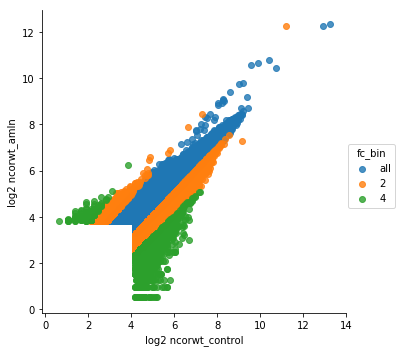

In [65]:
ncorwt_peaks = compare_idr(outdir + 'ncorwt_amln', outdir + 'ncorwt_control', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


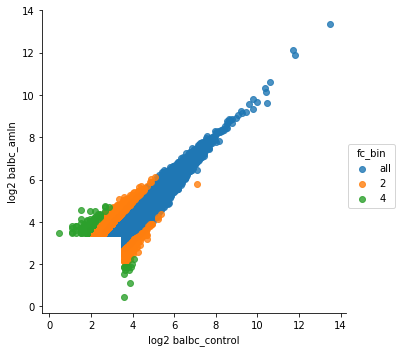

In [66]:
balb_peaks = compare_idr(outdir + 'balbc_amln', outdir + 'balbc_control', outdir, dist='given')

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_aj_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_aj_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


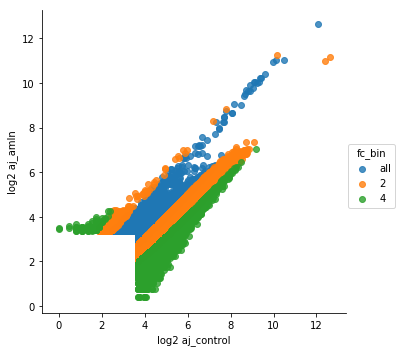

In [67]:
aj_peaks = compare_idr(outdir + 'aj_amln', outdir + 'aj_control', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


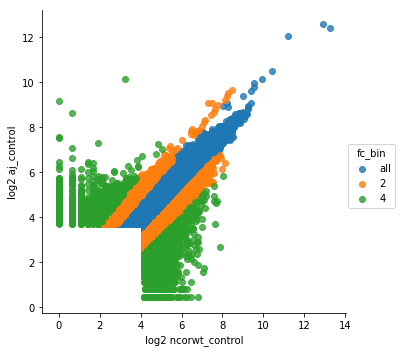

In [68]:
aj_ncorwt_control = compare_idr(outdir + 'aj_control', outdir + 'ncorwt_control', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


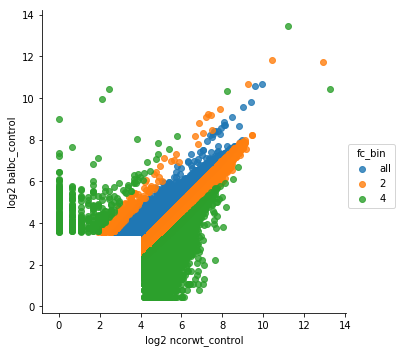

In [69]:
balbc_ncorwt_control = compare_idr(outdir + 'balbc_control', outdir + 'ncorwt_control', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


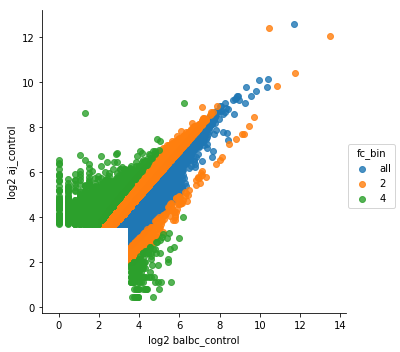

In [70]:
aj_balbc_control = compare_idr(outdir + 'aj_control', outdir + 'balbc_control', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


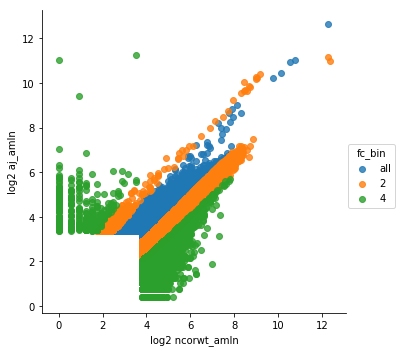

In [71]:
aj_ncorwt_amln = compare_idr(outdir + 'aj_amln', outdir + 'ncorwt_amln', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


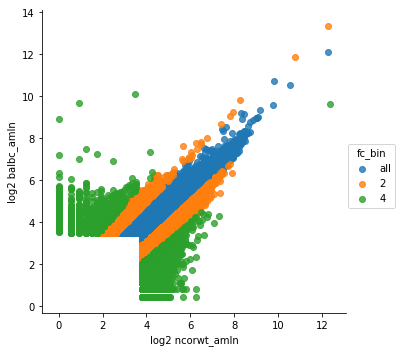

In [72]:
balbc_ncorwt_amln = compare_idr(outdir + 'balbc_amln', outdir + 'ncorwt_amln', outdir, dist='given')

calling mergePeaks...
calling annotatePeaks...


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


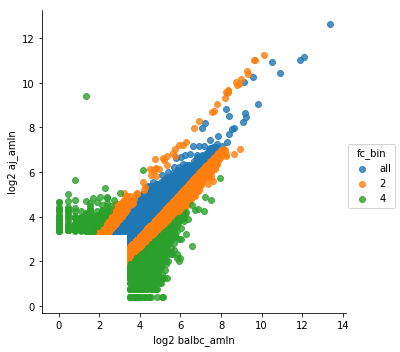

In [73]:
aj_balbc_amln = compare_idr(outdir + 'aj_amln', outdir + 'balbc_amln', outdir, dist='given')

In [17]:
mp = ["mergePeaks", "-d", "200", 
      outdir + "aj_amln/optimal_peakfile.txt", outdir + "aj_control/optimal_peakfile.txt",
      outdir + "balbc_amln/optimal_peakfile.txt", outdir + "balbc_control/optimal_peakfile.txt",
      outdir + "ncorwt_amln/optimal_peakfile.txt", outdir + "ncorwt_control/optimal_peakfile.txt"]
p = subprocess.Popen(mp, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, err = p.communicate()
f = open(outdir + "atac_union.txt", 'w')
f.write(output.decode("utf-8"))
f.close()

mergePeaks -d 200 aj_amln/optimal_peakfile.txt aj_control/optimal_peakfile.txt balbc_amln/optimal_peakfile.txt balbc_control/optimal_peakfile.txt ncorwt_amln/optimal_peakfile.txt ncorwt_control/optimal_peakfile.txt > atac_union.txt


In [27]:
ap = ["annotatePeaks.pl", outdir + "atac_union.txt", "mm10", "-noann", "-nogene", '-noadj', "-d"]
ap.extend(samplesDF.path)
p = subprocess.Popen(ap, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, err = p.communicate()
f = open(outdir + "ann_atac_union.txt", 'w')
f.write(output.decode("utf-8"))
f.close()

annotatePeaks.pl atac_union.txt mm10 -noann -nogene -noadj -d /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_16_09_28 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_ControlDiet_30week_Balb1A_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_ControlDiet_30week_Balb1B_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19 /data/mm10/Kupffer/ATAC/NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21 /data/mm10/Kupffer/ATAC/NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134B_JSS_TDT_16_09_21 /data/mm10/K

Total peaks across all samples (from annotatePeaks.pl Total Peaks: 69430)

In [19]:
# read in the ATAC counts data
atac = pd.read_csv(outdir + 'ann_atac_union.txt', sep='\t')
atac.columns.values[0] = 'PeakID'
atac = atac.set_index('PeakID')
counts_mat_k = atac.iloc[:, 6:]
# Column Data Information for DESeq, make sure to drop the samples we are excluding
col_data_k = samplesDF.loc[(samplesDF.sample_type=='kupffer') & ~samplesDF.exclusion,
                           ['subject', 'strain', 'diet', 'sample_type']]
col_data_k = col_data_k.set_index('subject')